In [1]:
import pandas as pd
import pystan
import arviz as az
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

In [6]:
#We import the data.
data = pd.read_csv(r'C:\Users\HP\Desktop\chwytak\Data Analytics\airlines.csv')
data.head()

,Year,Fatal accidents,Passenger deaths,Death rate,Miles flown [100 mln miles]
0,1976,24,734,0.19,3863.0
1,1977,25,516,0.12,4300.0
2,1978,31,754,0.15,5027.0
3,1979,31,877,0.16,5481.0
4,1980,22,814,0.14,5814.0


In [14]:
#In the first model we consider number of passenger deaths to have a Poisson distribution with a constant rate (lambda).
#Using three-sigma rule, we may find lambda, for which probability of 5 people dying every day
#(i.e. 1825 per year) is not greater than 1%.
#We solve the equation: lamda + 3*sqrt(lambda) = 1825.
lambdaRoots = np.roots([1, 3, -1825])
for lambdaRoot in lambdaRoots:
    if lambdaRoot > 0:
        print('Lambda root: {}'.format(lambdaRoot**2))

Lambda root: 1701.2609653810505


In [8]:
#We need to find a distribution that will guarantee that 99% of probability lies below 1701. 
#We may use a half-normal distribution, which is a doubled absolute value of normal distribution.
#Using Stan, we find value of its variance, so that the above condition is met.
halfNormal99 = """
functions {
    vector tail_halfNormal (vector y, vector theta, real[] x_r, int[] x_i) {
        vector[1] deltas;
        deltas[1] = 2*(normal_cdf(theta[1], 0, exp(y[1])) - 0.5) - 0.99;
        return deltas;
    }
}
data {
    vector[1] y_guess;
    vector[1] theta;
}
transformed data {
    vector[1] y;
    real x_r[0];
    int x_i[0];
    y = algebra_solver(tail_halfNormal, y_guess, theta, x_r, x_i);
}
generated quantities {
    real sigma = exp(y[1]);
}

"""
halfNormal99Model = pystan.StanModel(model_code = halfNormal99)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_131d781230817473c6db11d99f43d4ca NOW.


In [15]:
dataHalfNormal99 = {'y_guess': np.array([np.log(565)]), 'theta': np.array([1701])}
sim_pcc_99 = halfNormal99Model.sampling(data = dataHalfNormal99, algorithm = 'Fixed_param', iter = 1)
print('Sigma: {}'.format(sim_pcc_99.extract()['sigma'][0]))

Sigma: 660.3698458032177


In [27]:
#We now know that lambda having a half-normal distribution (0, 660) will guarantee that with 99%
#probability there will be less than 5 deaths per day.
#We may now model our prior distribution.
prior = """
data {
    int M;
}
generated quantities {
    real lambda = fabs(normal_rng(0, 660));
    int y_sim[M];
    for(k in 1:M) {
        y_sim[k] = poisson_rng(lambda);
    }        
}
"""
priorModel = pystan.StanModel(model_code = prior)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5605b952c7234e00fa6bcee2eec4eb08 NOW.


In [53]:
dataPrior = {'M': 1}
sim_pcc_prior = priorModel.sampling(data = dataPrior, algorithm = 'Fixed_param', iter = 1000)
paramsLambda = pd.DataFrame(sim_pcc_prior.extract()['lambda'])
paramsDeaths = pd.DataFrame(sim_pcc_prior.extract()['y_sim'])
params = paramsLambda.merge(paramsDeaths, left_index = True, right_index = True)
params.columns = ['lambda', 'deaths']

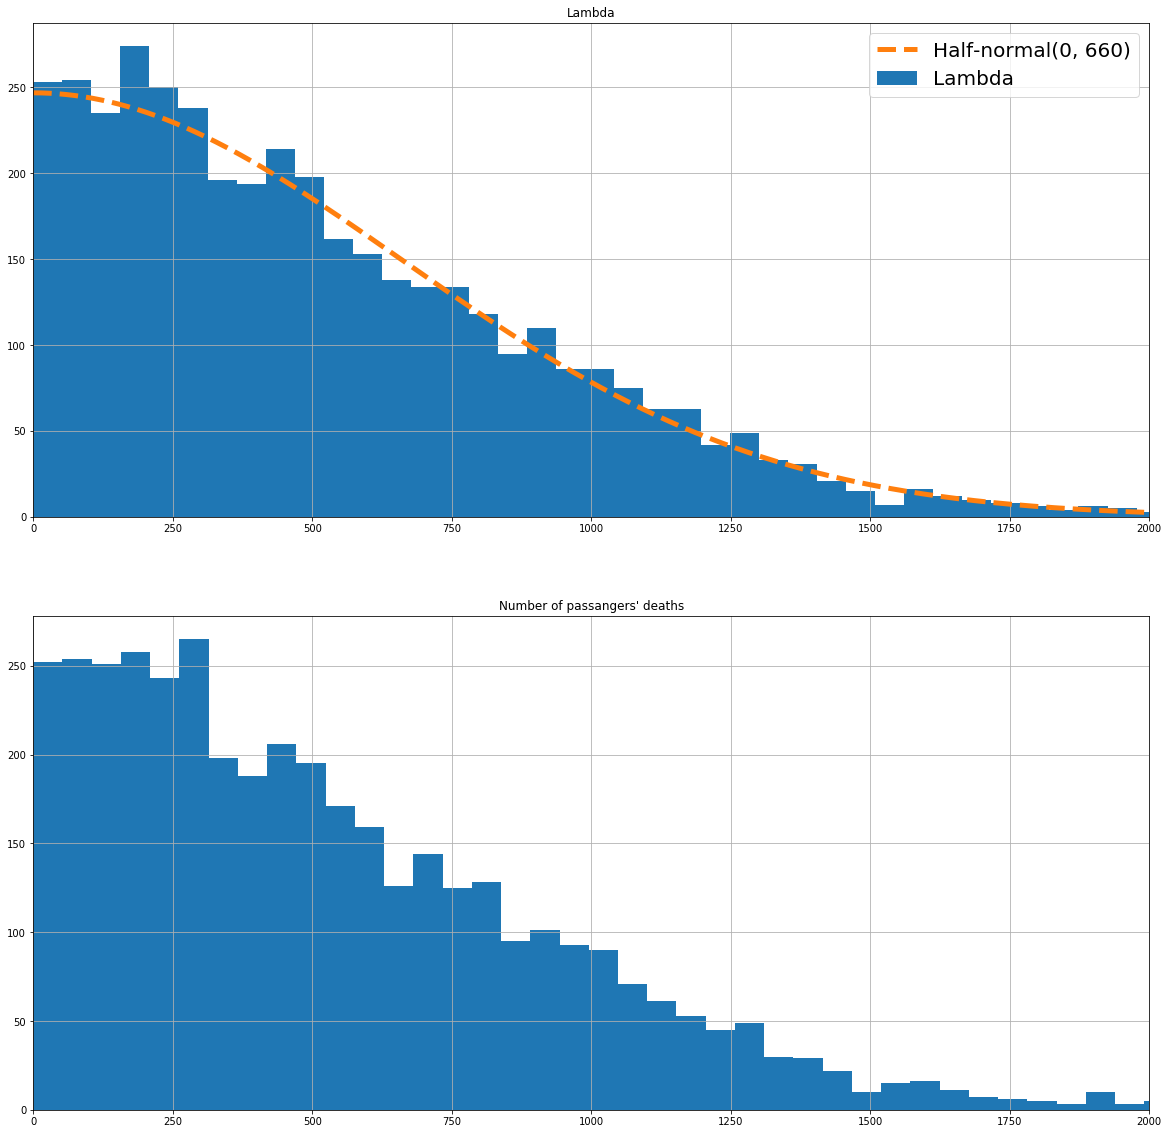

In [60]:
#We plot the histograms of lambda and number of deaths.
fig, axes = plt.subplots(2, 1, figsize = [20, 20])
ax1 = axes[0]
x = np.linspace(0, 2000, 20000)
ax1.set_title('Lambda')
ax1.set_xlim([0, 2000])
ax1.hist(params['lambda'], bins = 50, label = 'Lambda')
ax1.plot(x, 408333*stats.norm.pdf(x, 0, 660), '--', linewidth = 5, label = 'Half-normal(0, 660)')
ax1.grid()
ax1.legend(prop = {'size': 20})
ax2 = axes[1]
ax2.set_title('Number of passangers\' deaths')
ax2.set_xlim([0, 2000])
ax2.hist(params['deaths'], bins = 50)
ax2.grid()
plt.show()

In [61]:
#Now we prepare model with posterior inference.
posterior = """
data {
    int M;
    int y[M];
}
parameters {
    real<lower=0>lambda;
}
model {
    lambda ~ normal(0, 660);
    for (k in 1:M) {
        y[k] ~ poisson(lambda);
    }
}
generated quantities {
    int y_sim[M];
    for (k in 1:M) {
        y_sim[k] = poisson_rng(lambda);
    }
}
"""
posteriorModel = pystan.StanModel(model_code = posterior)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_917d5513793d5dbde5dc1ae0a2e64fdb NOW.


In [70]:
dataPosterior = {'M': data.shape[0], 'y': data['Passenger deaths']}
sim_pcc_posterior = posteriorModel.sampling(data = dataPosterior, algorithm = 'Fixed_param', iter = 1000)
paramsLambda = pd.DataFrame(sim_pcc_posterior.extract()['lambda'])
paramsDeaths = pd.DataFrame(sim_pcc_posterior.extract()['y_sim'])
params = paramsLambda.merge(paramsDeaths, left_index = True, right_index = True)
params.head()

,0_x,0_y,1,2,3,4,5,6,7,8,9
0,2.158367,1.0,4.0,2.0,6.0,2.0,4.0,3.0,2.0,0.0,2.0
1,2.158367,0.0,2.0,4.0,1.0,4.0,1.0,0.0,3.0,3.0,3.0
2,2.158367,5.0,5.0,1.0,2.0,2.0,3.0,0.0,2.0,4.0,1.0
3,2.158367,2.0,1.0,3.0,0.0,3.0,2.0,4.0,1.0,2.0,3.0
4,2.158367,3.0,3.0,2.0,2.0,4.0,2.0,0.0,1.0,1.0,3.0
